In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import ops

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
num_classes = 100 # クラス数(分類するカテゴリの数)
input_shape = (32, 32, 3) # 入力画像の形状(高さ,幅,チャンネル数)
patch_size = (2, 2) # パッチのサイズ(2x2ピクセル)
dropout_rate = 0.06 # ドロップアウト率
num_heads = 8 # ヘッドの数
embed_dim = 64  # 埋め込み次元(特徴ベクトルの次元数)
num_mlp = 256  # 全結合層のユニット数

qkv_bias = True  # クエリ,キー,バリューに変換する際に学習可能なバイアスを追加
window_size = 2 # ウィンドウのサイズ
shift_size = 1 # ウィンドウのシフト量

image_dimension = 32 # 初期画像サイズ
num_patch_x = input_shape[0] // patch_size[0] # パッチ数(高さ方向)
num_patch_y = input_shape[1] // patch_size[1] # パッチ数(幅方向)

learning_rate = 1e-3  # 学習率
batch_size = 128  # バッチサイズ
num_epochs = 300  # エポック数
validation_split = 0.1 # 検証用データの割合
weight_decay = 0.0001 # 重み減衰の割合（L2正則化の強さ）
# ラベル平滑化の係数。0から1の値を取り、1に近いほどラベルを平滑化する
label_smoothing = 0.1


In [ ]:
# CIFAR-100データセットを読み込む
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
# 画像データを0.0-1.0の範囲に正規化
x_train, x_test = x_train / 255.0, x_test / 255.0
# トレーニングラベルをワンホットエンコーディングに変換
y_train = keras.utils.to_categorical(y_train, num_classes)
# テストラベルをワンホットエンコーディングに変換
y_test = keras.utils.to_categorical(y_test, num_classes)
# トレーニングデータのサンプル数を計算
num_train_samples = int(len(x_train) * (1 - validation_split))
# 検証データのサンプル数を計算
num_val_samples = len(x_train) - num_train_samples
# トレーニングデータをトレーニング用と検証用に分割
x_train, x_val = np.split(x_train, [num_train_samples])
# トレーニングラベルをトレーニング用と検証用に分割
y_train, y_val = np.split(y_train, [num_train_samples])
# トレーニングデータとラベルの形状を表示
print(f"x_train shape: {x_train.shape} --- y_train shape: {y_train.shape}")
# テストデータとラベルの形状を表示
print(f"x_test shape: {x_test.shape} --- y_test shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
x_train shape: (45000, 32, 32, 3) --- y_train shape: (45000, 100)
x_test shape: (10000, 32, 32, 3) --- y_test shape: (10000, 100)


In [ ]:
def patch_extract(images):
    """ 画像データをサイズ2×2のパッチに分割する

    Args:
        images: データ拡張後の画像のテンソル:(bs, 32, 32, 3)
    Returns:
        パッチに分割後、再整形したテンソル
        (bs, 256(パッチ数), 12(パッチの次元数))
    """
    # バッチデータのサイズを取得(batch_size=128)
    batch_size = tf.shape(images)[0]
    # 入力画像からパッチを抽出
    # sizeオプションにパッチサイズ(2,2)を設定
    # 32×32×3を2×2のパッチに分割
    # 元の画像は高さ方向16、幅方向16に分割され、合計256個のパッチになる
    # パッチ1個あたりの特徴量次元は2×2×3(チャンネル)＝12
    # (bs, 32, 32, 3)--->(bs, 16, 16, 12)
    patches = tf.image.extract_patches(
        # データ拡張後の画像のテンソル
        images=images,
        # 抽出するパッチのサイズ(patch_size = (2, 2))を指定: (1, 2, 2, 1)
        sizes=(1, patch_size[0], patch_size[1], 1),
        # ストライドサイズはパッチサイズと同じ: 縦方向2、横方向2
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1), # サンプリングレート
        padding="VALID", # パディングは行わない
    )
    # パッチ1個当たりの次元数を取得(patch_dim=12)
    patch_dim = patches.shape[-1]
    # パッチの縦方向の数を取得(patch_num=16)
    patch_num = patches.shape[1]
    # (bs, パッチの数(patch_num * patch_num), patch_dim)の形状に再整形して返す
    # (bs, 256, 12)
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


In [ ]:
class PatchEmbedding(layers.Layer):
    """ 全結合層、Embedding層から成るブロックを定義するクラス
        位置情報の埋め込みを行う

    Attributes:
        num_patch: パッチの数
        proj(layers.Dense): パッチデータを拡張する全結合層
        pos_embed(ayers.Embedding): パッチの位置埋め込み層
    """
    def __init__(self, num_patch, embed_dim, **kwargs):
        """
        Args:
            num_patch: パッチの数(16*16=256)
            embed_dim: 埋め込み次元数(embed_dim = 64)
            **kwargs: その他のキーワード引数
        """
        super().__init__(**kwargs)
        # 画像1枚当たりのパッチ数を設定
        self.num_patch = num_patch
        # 位置情報を埋め込むためにチャンネル次元を拡張する全結合層
        # ユニット数: embed_dim = 64
        self.proj = layers.Dense(embed_dim)
        # エンベッディング(埋め込み)を行うレイヤー
        # input_dimの次元数に対して、output_dimの数だけ
        # 学習可能なパラメーターが作成される
        # 作成されるパラメーターテンソルの形状: (256, 64)
        # パラメーター数: 256*64=16,384
        self.pos_embed = layers.Embedding(
            input_dim=num_patch, # 入力の次元数(パッチの数(16*16=256))
            output_dim=embed_dim # 作成するエンベッディングベクトルの次元数(embed_dim = 64)
        )

    def call(self, patch):
        """ フォワードパス(順伝搬処理)

        Args:
            patch: パッチに分割後のテンソル(bs, num_patch(256), patch_dim(12))
        Returns:
            位置情報埋め込み後のテンソル(bs, num_patch(256), embed_dim(64))
        """
        # Embeddingレイヤーのパラメーター値を取得するためのインデックスとして
        # 要素が[0, 1, 2, ..., 255]、形状が(256,)の1階テンソルを作成
        pos = ops.arange(start=0, stop=self.num_patch)

        # パッチに分割後のテンソルをユニット数(64)の全結合層で
        # (bs, 256, 64)にチャンネル次元数を64に拡張
        #
        # Embeddingレイヤーにインデックスposを入力してパラメーター値を
        # 形状(256, 64)のテンソルとして取得
        #
        # 変換後の画像データ(bs, 256, 64)に対して、位置情報(256, 64)を加算
        # 戻り値のテンソルの形状: (bs, 256, 64)
        return self.proj(patch) + self.pos_embed(pos)


In [ ]:
def window_partition(x, window_size):
    """ 入力画像をウィンドウに分割する
    Args:
        x: (bs, 16(高さ方向パッチ数), 16(幅方向パッチ数), 64(チャンネル数))
        window_size(int): ウィンドウ1辺のサイズ(window_size = 2)

    Returns:
        ウィンドウに分割後の特徴マップ
        (bs * 8(高さ方向ウィンドウ数) * 8(幅方向ウィンドウ数),
        2(ウィンドウサイズ(高さ方向)), 2(ウインドウサイズ(幅方向)), 64)
    """
    # (bs, 16(高さ方向パッチ数), 16(幅方向パッチ数), 64(チャンネル数))から
    # さ方向パッチ数、幅方向パッチ数、チャンネル数を取得
    _, height, width, channels = x.shape
    # 高さ方向のウィンドウ数を計算
    patch_num_y = height // window_size
    # 幅方向のウィンドウの数を計算
    patch_num_x = width // window_size

    # 入力画像xをウィンドウサイズに基づいて再整形する
    # 処理後の形状: (bs, 8, 2, 8, 2, 64)
    x = ops.reshape(
        x,  # 入力テンソル
        (
            -1,  # bs(バッチサイズ)はそのまま
            patch_num_y,  # 高さ方向のウィンドウ数
            window_size,  # ウィンドウの高さ方向のサイズ
            patch_num_x,  # 幅方向のウィンドウ数
            window_size,  # ウィンドウの幅方向のサイズ
            channels,  # チャンネル数
        ),
    )

    # テンソルxを
    # (bs, ウィンドウ数(高さ方向),
    #      ウィンドウ数(幅方向),
    #      ウィンドウサイズ(高さ方向),
    #      ウインドウサイズ(幅方向),
    #      チャンネル数)
    # の順に並べ換える。 処理後の形状: (bs, 8, 8, 2, 2, 64)
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))

    # 並べ換えた次元に沿ってテンソルを再整形(データを新しい形状に再配置)する
    # 形状: (bs * 8(高さ方向ウィンドウ数) * 8(幅方向ウィンドウ数),
    #        2(ウィンドウサイズ(高さ方向)), 2(ウインドウサイズ(幅方向)), 64)
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


In [ ]:
def window_reverse(windows, window_size, height, width, channels):
    """ ウィンドウへの分割を解除して元の特徴マップの形状に戻す
    Args:
        windows: (bs * 8 * 8, 2, 2, 64)
        window_size(int): ウィンドウのサイズ(window_size = 2)
        height(int): 1画像当たりのパッチ数(16(高さ))
        width(int): 1画像当たりのパッチ数(16(幅))
        channels: チャンネル数(64)

    Returns:
        x: ウィンドウ分割を解除したテンソル
           (bs, 16(高さ方向パッチ数), 16(幅方向パッチ数), 64(チャンネル数))
    """
    # 高さ方向のウィンドウ数を計算
    # patch_num_y  = 8
    patch_num_y = height // window_size
    # 幅方向のウィンドウの数を計算
    # patch_num_x = 8
    patch_num_x = width // window_size

    # 入力テンソルwindowsをウィンドウサイズに基づいて再整形する
    # (bs * 8 * 8, 2, 2, 64) -> (bs, 8, 8, 2, 2, 64)
    x = ops.reshape(
        windows,  # 入力テンソル
        (
            -1,  # 第1次元は自動計算
            patch_num_y,  # 高さ方向のウィンドウ数
            patch_num_x,  # 幅方向のウィンドウ数
            window_size,  # ウィンドウの高さ
            window_size,  # ウィンドウの幅
            channels,  # チャンネル数
        ),
    )

    # 転置して元の次元の並びに戻す
    # (bs, 8(ウィンドウ数-高さ), 2(サイズ-高さ), 8(ウィンドウ数-幅), 2(サイズ-幅), 64)
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))

    # ウィンドウ分割前の形状に再整形する
    # (bs, 16(高さ方向パッチ数), 16(幅方向パッチ数), 64(チャンネル数))
    x = ops.reshape(x, (-1, height, width, channels))

    return x


In [ ]:
class WindowAttention(layers.Layer):
    """ layers.Layerを継承したカスタムレイヤー
        W-MSA、SW-MSAベースのSelf-Attention機構を実装する

    Attributes:
        dim(int): 入力特徴量の次元数(位置情報の次元数(embed_dim = 64))
        window_size: ウィンドウの形状(高さ=2, 幅=2)
        num_heads: ヘッドの数(num_heads = 8)
        scale: クエリベクトルをスケーリングするための係数
        qkv: クエリ、キー、バリューを生成するための全結合層
        dropout: ドロップアウト率(dropout_rate = 0.06)
        proj: 出力を生成するための全結合層
    """
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        """
        Args:
            dim(int): 入力特徴量の次元数(位置情報の次元数(embed_dim = 64))
            window_size(tuple): ウィンドウの形状(2(高さ), 2(幅))
            num_heads(int): ヘッドの数(num_heads = 8)
            qkv_bias(bool): クエリ、キー、バリューにバイアスを追加するかどうか
                            (qkv_bias = True)
            dropout_rate(float): ドロップアウト率(dropout_rate = 0.06)
            **kwargs(dict): その他のキーワード引数
        """
        super().__init__(**kwargs)
        # 位置情報の次元数(embed_dim = 64))を入力特徴量の次元数として設定
        self.dim = dim
        # ウィンドウの形状(window_size(縦方向=7), window_size(行方向=7))を設定
        self.window_size = window_size
        # ヘッドの数(num_heads = 8)を設定
        self.num_heads = num_heads
        # クエリベクトルをスケーリングする係数を計算
        self.scale = (dim // num_heads) ** -0.5

        # クエリ、キー、バリューを生成する全結合層を作成
        # ユニット数: 入力次元数(64) * 3 = 192
        # バイアスを使用する
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        # ドロップアウト(dropout_rate = 0.06)レイヤーを作成
        self.dropout = layers.Dropout(dropout_rate)
        # 出力層を作成
        # ユニット数: 入力次元数=64
        self.proj = layers.Dense(dim)
        # ウィンドウ内パッチ間の相対位置の組み合わせを計算
        # (2 * 2 - 1) * (2 * 2 - 1) = 9
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )

        # 相対位置エンコーディングを学習するパラメーター(重み)を作成
        # テンソル形状: (9, 8)
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads), # パラメーターの形状: (9, 8)
            initializer=keras.initializers.Zeros(), # パラメーター値をゼロで初期化
            trainable=True, # パラメーター値を更新する
        )
        # ウィンドウの高さ方向の座標を生成
        # coords_h = [0 1]
        coords_h = np.arange(self.window_size[0])

        # ウィンドウの幅方向の座標を生成
        # coords_w = [0 1]
        coords_w = np.arange(self.window_size[1])
        # 座標のグリッドを生成
        # coords_matrix[0]: [[0, 0], [1, 1]]y座標(縦方向)の変化
        # coords_matrix[1]: [[0, 1], [0, 1]]x座標(横方向)の変化
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        # 座標のグリッドをスタック
        # coordsの形状: (2, 2, 2)
        coords = np.stack(coords_matrix)
        # coordsの形状を再整形する。-1は自動計算される次元のサイズ
        # (2, 2, 2)  --> (2, 4)
        coords_flatten = coords.reshape(2, -1)

        # 相対位置の計算
        # 各座標ペアについて、(x座標, y座標)の差を計算して、
        # ウィンドウ内のすべてのy座標の相対位置とx座標の相対位置を求める
        # relative_coordsの形状: (2, 4, 4)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        # 転置して(4, 4, 2)の形状にする
        # 最後の次元で(y座標の相対位置, x座標の相対位置)のように、相対位置のペアを作る
        relative_coords = relative_coords.transpose([1, 2, 0])
        # y座標の相対位置に1を加えることで、y座標の相対位置をすべて正の値にする
        relative_coords[:, :, 0] += self.window_size[0] - 1
        # x座標の相対位置に1を加えることで、x座標の相対位置をすべて正の値にする
        relative_coords[:, :, 1] += self.window_size[1] - 1
        # y座標の相対位置をスケーリング
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        # 最後の次元の(y座標の相対位置, x座標の相対値)の合計を求め、一意のインデックスを生成
        relative_position_index = relative_coords.sum(-1)
        # 相対位置インデックスを変数として保存
        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )


    def call(self, x, mask=None):
        """ フォワードパスを設定

        Args:
            x: ウィンドウ分割後、再整形されたテンソル
               (bs * ウィンドウ数, ウィンドウ内パッチ数, チャンネル数)
               (bs * 8 * 8, 2 * 2, 64)
            mask: マスク(64, 4, 4)

        Returns:
            x_qkv: アテンション後の出力テンソル
        """
        # ウィンドウ内パッチ数(4)、チャンネル数(64)を取得
        _, size, channels = x.shape
        # チャンネル次元数をヘッドの数(num_heads = 8)で割ってヘッドごとの次元数を計算
        head_dim = channels // self.num_heads
        # クエリ、キー、バリューを生成するための全結合層でチャンネル次元数を拡張
        # ユニット数: チャンネル次元数(64) * 3 = 192
        # 出力: (bs * 8 * 8, 4(ウィンドウ内パッチ数), 192)
        x_qkv = self.qkv(x)

        # チャンネル次元数192を順次分割: 192 -> 3(q,k,v) -> ヘッド数(8) -> ヘッドサイズ(8)
        #(bs * 64(ウィンドウ数, 4(ウィンドウ内パッチ数),3(q,k,v),8(ヘッド数),8(ヘッドサイズ))
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        # 第1次元をqkvにして、ヘッド(8)に分割
        # (3(q,k,v),bs*64(ウィンドウ数),8(ヘッド数),4(ウィンドウ内パッチ数),8(ヘッドサイズ))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        # クエリ、キー、バリューに分割
        # (bs * 64(ウィンドウ数, 8(ヘッド数), 4(ウィンドウ内パッチ数), 8(ヘッドサイズ))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]

        # クエリをスケーリング
        q = q * self.scale
        # キーを転置
        # (bs * 64(ウィンドウ数), 8(ヘッド数), 8(ヘッドサイズ), 4(ウィンドウ内パッチ数))
        k = ops.transpose(k, (0, 1, 3, 2))
        # 類似度スコアを計算
        # 第2次元はヘッドの数、第3次元と第4次元は、ウィンドウ内の
        # すべてのパッチの組み合わせによる類似度を示す
        # (bs * 16, 8(ヘッド数), 4, 4)
        attn = q @ k
        # ウィンドウ内のパッチ数を計算
        # num_window_elements = 4
        num_window_elements = self.window_size[0] * self.window_size[1]
        # 相対位置インデックスをフラット化
        # (4, 4) -> (16,)
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        # 相対位置エンコーディングを取得
        # (16(相対位置インデックスの数), 8(ヘッド数))
        relative_position_bias = ops.take(
            # 相対位置エンコーディングを学習するパラメーター(9, 8)
            self.relative_position_bias_table,
            # 相対位置インデックス(16,)
            relative_position_index_flat,
            # 第1次元に沿って収集する
            axis=0,
        )

        # 相対位置エンコーディングの形状を変換
        # (16(相対位置インデックスの数), 8(ヘッド数))
        #    -->(4(ウィンドウ内パッチ数), 4(ウィンドウ内パッチ数), 8(ヘッド数))
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        # 次元の並びを入れ換える
        # (4, 4, 8) => (8, 4, 4)
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        # アテンションスコアの計算
        # relative_position_biasの形状(1, 8, 4, 4)を(bs * 16, 8, 4, 4) に拡張し、
        # 類似度スコアに加算してアテンションスコアにする
        # attn形状: (bs * 16, 8(ヘッド数), 4, 4)
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        # マスクの処理
        # マスクテンソルの形状: (64, 4, 4)
        if mask is not None:
            # マスクのウィンドウ数を取得(nW = 64)
            nW = mask.shape[0]
            # マスクテンソルの第2次元を追加し、さらに第1次元を追加:(1, 64, 1, 4, 4)
            # テンソルのデータ型をfloat型にキャスト
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            # アテンションスコアの形状を再整形する
            # (bs * 64, 8, 4, 4) --> (bs, 64, 8, 4, 4)
            # マスク(64, 4, 4)をブロードキャストで加算
            # attn形状: (bs, 64, 8, 4, 4)
            attn = ops.reshape(
                attn, (-1, nW, self.num_heads, size, size)
                ) + mask_float
            # attnの形状を変換
            # (bs, 64, 8, 4, 4) --> (bs * 64, 8, 4, 4)
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            # ソフトマックスを適用
            # attn形状: (bs * 64, 64, 8, 4, 4)
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            # ソフトマックスを適用
            # attn形状: (bs * 64, 64, 8, 4, 4)
            attn = keras.activations.softmax(attn, axis=-1)

        # ドロップアウトを適用
        # attn形状: (bs * 64, 64, 8, 4, 4)
        attn = self.dropout(attn)
        # アテンションスコアにバリューを適用
        # 出力: (bs * 64, 8, 4, 8)
        x_qkv = attn @ v
        # x_qkvの次元の並びを変更
        # (bs * 64, 4, 8, 8)
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        # x_qkvを再整形
        # (bs * 64, 4, 64)
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        # ユニット数64の全結合層に入力して出力を生成
        # (bs * 64, 4, 64)
        x_qkv = self.proj(x_qkv)
        # ドロップアウトを適用
        # (bs * 64, 4, 64)
        x_qkv = self.dropout(x_qkv)

        return x_qkv


In [ ]:
class SwinTransformer(layers.Layer):
    """ layers.Layerを継承したカスタムレイヤー

    ・パッチ分割後の画像データをウィンドウに分割
    ・各ウィンドウに対してW-MSA、SW-MSAによる自己注意機構を適用
    ・ウィンドウに分割されたテンソルを元の形状に戻した状態で
      MLP層を組み合わせて、画像の特徴抽出と表現を学習する

    Attributes:
        dim(int): 入力特徴量の次元数(位置情報の次元数(embed_dim = 64))
        num_patch(tuple): 1画像当たりのパッチ数(高さ=16, 幅=16))
        num_heads(int): ヘッドの数(num_heads = 8)
        window_size(int): ウィンドウのサイズ
        shift_size(int): ウィンドウのシフトサイズ(shift_size = 1)
        num_mlp(int): 全結合層のユニット数(num_mlp = 256)
        norm1: layers.LayerNormalization - 1つ目のLayer Normalization層。
        attn: WindowAttention - ウィンドウベースの自己注意層。
        drop_path: layers.Dropout - ドロップアウト層。
        norm2: layers.LayerNormalization - 2つ目のLayer Normalization層。
        mlp: keras.Sequential - MLP層のシーケンシャルモデル。
    """
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        """
        Args:
            dim(int): 位置情報埋め込み後のチャンネル次元数(embed_dim = 64)
            num_patch(tuple): 1画像当たりのパッチ数(高さ=16, 幅=16)
            num_heads(int): ヘッドの数(num_heads = 8)
            window_size(int): ウィンドウのサイズ(window_size = 2)
            shift_size(int): ウィンドウのシフトサイズ(shift_size = 1)
            num_mlp(int): 全結合層のユニット数(num_mlp = 256)
            qkv_bias(bool): クエリ、キー、バリューにバイアスを追加するかどうか
                            (qkv_bias = True)
            dropout_rate(float): ドロップアウト率
            **kwargs(dict): その他のキーワード引数

        """
        super().__init__(**kwargs)
        # 位置情報埋め込み後のチャンネル次元数(embed_dim = 64)を
        # 入力特徴量の次元数として設定
        self.dim = dim
        # 1画像当たりのパッチ数(高さ=16, 幅=16)を設定
        self.num_patch = num_patch
        # ヘッドの数(num_heads = 8)を設定
        self.num_heads = num_heads
        # ウィンドウのサイズ(window_size = 2)を設定
        self.window_size = window_size
        # ウィンドウのシフトサイズ(shift_size = 1)を設定
        self.shift_size = shift_size
        # 全結合層のユニット数(num_mlp = 256)を設定
        self.num_mlp = num_mlp

        # 1つ目の正規化層を作成
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)

        # WindowAttentionブロックを作成
        self.attn = WindowAttention(
            # 位置情報埋め込み後のチャンネル次元数(embed_dim = 64)
            dim,
            # ウィンドウの形状(window_size=2(高さ), window_size=2(幅))
            window_size=(self.window_size, self.window_size),
            # ヘッドの数(num_heads = 8)
            num_heads=num_heads,
            # クエリ、キー、バリューにバイアスを追加する(qkv_bias = True)
            qkv_bias=qkv_bias,
            # ドロップアウト率(dropout_rate = 0.06)
            dropout_rate=dropout_rate,
        )

        # ドロップアウト層を作成
        self.drop_path = layers.Dropout(dropout_rate)
        # 2つ目のLayer Normalization層を作成
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        # MLPを作成
        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp), # 全結合層(ユニット数:256)
                layers.Activation(keras.activations.gelu), # GELU関数を適用
                layers.Dropout(dropout_rate), # ドロップアウト
                layers.Dense(dim), # 全結合層(ユニット数:64)
                layers.Dropout(dropout_rate), # ドロップアウト
            ]
        )

        # パッチの数(高さ, 幅)がウィンドウの形状(高さ, 幅)より小さい場合
        if min(self.num_patch) < self.window_size:
            self.shift_size = 0  # シフトサイズを0に設定
            # ウィンドウサイズをパッチ数に合わせる
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        """ レイヤーにデータが最初に入力されたときに呼び出される

        Args:
            input_shape: 入力画像の形状(高さ,幅,チャンネル数)
                         (32, 32, 3)
        """
        # シフトサイズが0の場合
        if self.shift_size == 0:
            # マスクテンソルattn_maskをNoneに設定
            self.attn_mask = None
        else:
            # num_patch(高さ=16, 幅=16))からパッチの高さ方向の数と幅方向の数を取得
            height, width = self.num_patch
            # 高さ方向のスライスを作成
            # (window_size = 2, shift_size = 1と仮定)
            h_slices = (
                # 最初の領域: (0, －2)
                slice(0, -self.window_size),
                # 中間の領域: (-2, －1)
                slice(-self.window_size, -self.shift_size),
                # 最後の領域: (－1, None)
                slice(-self.shift_size, None),
            )
            # 幅方向のスライスを作成
            # (window_size = 2, shift_size = 1と仮定)
            w_slices = (
                # 最初の領域: (0, －2)
                slice(0, -self.window_size),
                # 中間の領域: (-2, －1)
                slice(-self.window_size, -self.shift_size),
                # 最後の領域: (－1, None)
                slice(-self.shift_size, None),
            )
            # マスク用のゼロ配列を作成
            # ・第1次元: バッチデータの次元（ここでは常に1）
            # ・第2次元: パッチの高さ方向の数
            # ・第3次元: パッチの幅方向の数
            # ・第4次元: チャンネル次元（ここでは常に1）
            mask_array = np.zeros((1, height, width, 1))

            # 各領域に割り当てる番号を保持するカウンター変数を0で初期化
            count = 0
            # 2重ループを使って2つのスライスを組み合わせ、
            # 各領域に対して番号を割り当てる
            for h in h_slices:  # 高さ方向のスライスに対して
                for w in w_slices:  # 幅方向のスライスに対して
                    mask_array[:, h, w, :] = count  # マスク配列にカウント値を設定
                    count += 1

            # マスク配列をテンソルに変換
            # (1, 16, 16, 1)
            mask_array = ops.convert_to_tensor(mask_array)
            # マスクテンソルをウィンドウに分割
            # (64, 2, 2, 1)
            mask_windows = window_partition(mask_array, self.window_size)
            # 再整形
            # (64, 4)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )

            # シフトした際のウィンドウ内パッチ間の相対的な位置関係の差分を計算
            # (64, 4, 4)
            attn_mask = ops.expand_dims(
                mask_windows, axis=1) - ops.expand_dims(mask_windows, axis=2)

            # 差がゼロではない領域(シフトによってウィンドウが重なる場合に
            # 発生する境界をまたぐ部分)を-100に設定
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            # 差がゼロの領域を0に設定
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            # テンソルattn_maskを変数として保存
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        """フォワードパスを設定

        Args:
            x: 位置情報埋め込み後の特徴マップ(bs, 256, 64)
            training(bool): トレーニングモードかどうか
        Returns:
            x: SwinTransformerブロックの出力(bs, 256(パッチ数), 64)
        """
        # num_patch(高さ=16, 幅=16))からパッチの高さ方向の数と幅方向の数を取得
        height, width = self.num_patch
        # 入力の特徴マップからパッチの数とチャンネルの次元数を取得
        _, num_patches_before, channels = x.shape
        # スキップ接続(残差接続)のために入力を保存
        x_skip = x
        # 入力を正規化
        x = self.norm1(x)
        # 特徴マップを再整形
        # (bs, 16(高さ方向パッチ数), 16(幅方向パッチ数), 64)
        x = ops.reshape(x, (-1, height, width, channels))

        # シフト処理
        # shifted_xの形状: (bs, 16, 16, 64)
        if self.shift_size > 0:
            # シフトサイズが0より大きい場合、特徴マップの第2次元(高さ方向パッチ数)
            # と第3次元(幅方向パッチ数)をshift_sizeに従ってシフトする
            shifted_x = ops.roll(
                x,
                shift=[-self.shift_size, -self.shift_size],
                axis=[1, 2]
            )
        else:
             # シフトが0以下の場合は特徴マップをそのままshifted_xに代入
            shifted_x = x

        # shifted_xをウィンドウに分割
        # x_windowsの形状:(bs * 64(ウィンドウ数),
        #                  2(ウィンドウ内パッチ数(高さ)),
        #                  2(ウインドウ内パッチ数(幅)),
        #                  64)
        x_windows = window_partition(shifted_x, self.window_size)

        # ウィンドウ内パッチ数の次元をフラット化して再整形
        # x_windowsの形状:(bs * 64(ウィンドウ数), 4(ウィンドウ内パッチ数), 64)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )

        # x_windowsをWindowAttentionブロックに入力
        # アテンションマスクself.attn_maskを適用してアテンションスコアを取得
        # attn_windowsの形状:(bs * 64, 4, 64)
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # attn_windowsを再整形する
        # (bs * 64, 2(ウィンドウ高さ), 2(ウィンドウ幅), 64)
        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )

        # attn_windowsをウィンドウ分割前の形状に戻し、shifted_xに代入
        # shifted_xの形状:(bs, 16(高さ方向パッチ数), 16(幅方向パッチ数), 64)
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )

        # シフト処理を行った場合はもう一度シフト処理を行ってシフト前の状態に戻す
        # xの形状:(bs, 16(高さ方向パッチ数), 16(幅方向パッチ数), 64)
        if self.shift_size > 0:
            # シフトサイズが0より大きい場合、shifted_xの第2次元(高さ方向パッチ数)
            # と第3次元(幅方向パッチ数)をshift_sizeに従ってシフトする
            x = ops.roll(
                shifted_x,
                shift=[self.shift_size, self.shift_size],
                axis=[1, 2]
            )
        else:
            # シフトを行わなかった場合はshifted_xをそのままxに代入
            x = shifted_x

        # xの形状:(bs, 16(高さパッチ数), 16(幅パッチ数), 64)
        # 再整形: (bs, 256(パッチ数), 64)
        x = ops.reshape(x, (-1, height * width, channels))
        # ドロップアウトを適用
        x = self.drop_path(x, training=training)
        # スキップ接続を適用
        x = x_skip + x
        # スキップ接続のために入力を保存
        x_skip = x
        # 正規化を行う
        x = self.norm2(x)
        # MLPに入力
        # 最終の全結合層(ユニット数:64)なので、xの形状は変わらない
        x = self.mlp(x)
        # ドロップアウトを適用
        x = self.drop_path(x)
        # スキップ接続を適用
        x = x_skip + x

        # xの形状:(bs, 256(パッチ数), 64)
        return x


In [ ]:
class PatchMerging(layers.Layer):
    """ layers.Layerを継承したカスタムレイヤー

    パッチを2x2のサイズにグループ化し、パッチグループ1個当たりの
    チャンネル次元数256(64 * 4)を線形変換で1/2の128にする

    Attributes:
        num_patch(tuple): パッチの数
        embed_dim(int): 埋め込み次元数
        linear_trans(layers.Dense):
            統合されたパッチのチャンネル次元を線形変換する全結合層
    """
    def __init__(self, num_patch, embed_dim):
        """
        Args:
            num_patch(tuple): 1画像当たりのパッチ数(高さ=16, 幅=16))
            embed_dim(int): 埋め込み次元数(embed_dim = 64)
        """
        super().__init__()
        # パッチの数(16, 16)を設定
        self.num_patch = num_patch
        # 埋め込み次元数を設定
        self.embed_dim = embed_dim
        # 統合されたパッチのチャンネル次元を線形変換する全結合層
        # ユニット数: 128(バイアス無し)
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        """ フォワードパス
        Args:
            x: SwinTransformerブロックから出力されたテンソル
               (bs, 256, 64)
        Returns:
            x: Patch Merging処理後のテンソル
               (bs, 64, 128)
        """
        # パッチの高さ方向の数(16)と幅方向の数(16)を取得
        height, width = self.num_patch
        # 入力テンソルのチャンネル次元数(64)を取得
        _, _, C = x.shape
        # 入力テンソルを再整形; (bs, 16, 16, 64)
        x = ops.reshape(x, (-1, height, width, C))

        # パッチを2x2の単位でまとめる(グループ化する)ための準備
        x0 = x[:, 0::2, 0::2, :]  # 偶数行・偶数列のパッチを取得:(bs, 8, 8, 64)
        x1 = x[:, 1::2, 0::2, :]  # 奇数行・偶数列のパッチを取得:(bs, 8, 8, 64)
        x2 = x[:, 0::2, 1::2, :]  # 偶数行・奇数列のパッチを取得:(bs, 8, 8, 64)
        x3 = x[:, 1::2, 1::2, :]  # 奇数行・奇数列のパッチを取得:(bs, 8, 8, 64)

        # 取得したパッチを上下左右2x2の単位でグループを作る
        # 64のパッチグループになる(縦方向8, 幅方向8)
        # xの形状: (bs, 8, 8, 256(チャンネル次元数64 * 4))
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        # グループ化された8x8のパッチを64(パッチグループ数)に再整形
        # (bs, 64(当初のパッチ数の1/4), 256(チャンネル次元数64 * 4))
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        # 64のパッチグループそれぞれのチャンネル次元数256を全結合層で128にする
        # 線形変換後のテンソル(bs, 64, 128)を返す
        return self.linear_trans(x)


In [ ]:
def augment(x):
    """ 入力画像に対してデータ拡張を行う

    Args:
        x: 入力画像テンソル。(32, 32, 3)
    Returns:
        x: 拡張処理後の画像テンソル。(32, 32, 3)
    """
    # ランダムクロップを適用
    # image_dimension = 32なので、画像のテンソルは(32, 32, 3)のまま
    x = tf.image.random_crop(
        x, size=(image_dimension, image_dimension, 3))
    # 左右反転を適用、画像のテンソルは(32, 32, 3)のまま
    x = tf.image.random_flip_left_right(x)
    return x

""" トレーニングデータセット

"""
dataset = (
    # トレーニングデータセットを入力テンソルx_trainとy_trainのスライスから作成
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    # augment()関数を適用して画像データを拡張処理
    .map(lambda x, y: (augment(x), y))
    # トレーニングデータをバッチ単位(batch_size=128)に分ける: (bs, 32, 32, 3)
    .batch(batch_size=batch_size)
    # 画像データにpatch_extract()関数を適用してパッチに分割: (bs, 256, 12)
    .map(lambda x, y: (patch_extract(x), y))
    # データの読み込みと前処理が非同期で行われるようにする
    .prefetch(tf.data.experimental.AUTOTUNE)
)

""" 検証データセット
    検証データセットにはデータ拡張を行わない
"""
dataset_val = (
    # 検証データセットを入力テンソルx_valとy_valのスライスから作成
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    # 検証データをバッチ単位(batch_size=128)に分ける: (bs, 32, 32, 3)
    .batch(batch_size=batch_size)
    # 画像データにpatch_extract()関数を適用してパッチに分割: (bs, 256, 12)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE) # 非同期処理の設定
)


""" テストデータセット
    テストデータセットにはデータ拡張を行わない
"""
dataset_test = (
    # テストデータセットを入力テンソルx_testとy_testのスライスから作成
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # テストデータをバッチ単位(batch_size=128)に分ける: (bs, 32, 32, 3)
    .batch(batch_size=batch_size)
    # 画像データにpatch_extract()関数を適用してパッチに分割: (bs, 256, 12)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE) # 非同期処理の設定
)


In [ ]:
""" SwinTransformerモデルの各ブロック(レイヤー)への順伝搬処理を定義

"""
# 入力レイヤー: モデルに入力されるのはパッチ分割後の画像テンソル
# 1画像当たり(256, 12)
input = layers.Input(shape=(256, 12))

# PatchEmbedding: パッチに分割後のテンソル(256, 12)に位置情報を埋め込む
# 位置情報埋め込み後の特徴マップの形状: (bs, 256, 64)
# num_patch_x = input_shape[0] // patch_size[0] # パッチ数(高さ方向)(16)
# num_patch_y = input_shape[1] // patch_size[1] # パッチ数(幅方向)(16)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)

# SwinTransformerブロック1:
# ここではシフトサイズが0なので、ウィンドウのシフトは行われない
# 出力xの形状: (bs, 256, 64)
x = SwinTransformer(
    dim=embed_dim, # 位置情報の次元数(embed_dim = 64)
    num_patch=(num_patch_x, num_patch_y), # パッチ数(高さ=16, 幅=16)
    num_heads=num_heads,  # ヘッドの数(num_heads = 8)
    window_size=window_size, # ウィンドウのサイズ(window_size = 2)
    shift_size=0, # シフトサイズ(シフトなし)
    num_mlp=num_mlp, # 全結合層のユニット数(num_mlp = 256)
    qkv_bias=qkv_bias,  # q、k、vにバイアスを追加する(qkv_bias = True)
    dropout_rate=dropout_rate,  # ドロップアウト率(dropout_rate = 0.06)
)(x)

# SwinTransformerブロック2:
# ここではシフトサイズが設定されているので、ウィンドウのシフトが行われる
# 出力xの形状: (bs, 256, 64)
x = SwinTransformer(
    dim=embed_dim,  # 位置情報の次元数(embed_dim = 64)
    num_patch=(num_patch_x, num_patch_y), # パッチ数(高さ=16, 幅=16)
    num_heads=num_heads,  # ヘッドの数(num_heads = 8)
    window_size=window_size,  # ウィンドウのサイズ(window_size = 2)
    shift_size=shift_size,  # シフトサイズ(shift_size = 1)を設定
    num_mlp=num_mlp, # 全結合層のユニット数(num_mlp = 256)
    qkv_bias=qkv_bias,  # q、k、vにバイアスを追加する(qkv_bias = True)
    dropout_rate=dropout_rate,  # ドロップアウト率(dropout_rate = 0.06)
)(x)

# Patch Merging
# 複数のパッチを統合し、解像度を下げる(チャンネル次元数を減らす)
# 出力xの形状:(bs, 64, 128)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)

# グローバル平均プーリング:
# 統合したパッチグループの全てのチャンネル次元を平均化し、チャンネル次元だけにする
# 出力xの形状:(bs, 128)
x = layers.GlobalAveragePooling1D()(x)

# 出力層:
# ユニット数100の全結合層を定義し、ソフトマックス関数を適用して各クラスの確率を出力
# outputの形状: (bs, 100)
output = layers.Dense(num_classes, activation="softmax")(x)


In [ ]:
%%time
# モデルを作成、コンパイルする
model = keras.Model(input, output)
model.compile(
    # 損失関数としてカテゴリカルクロスエントロピーを設定
    loss=keras.losses.CategoricalCrossentropy(
        # ラベル平滑化の係数を設定(label_smoothing = 0.1)
        label_smoothing=label_smoothing
    ),
    # オプティマイザー(最適化器)にAdamWを使用
    optimizer=keras.optimizers.AdamW(
        # learning_rate = 1e-3  # 学習率
        learning_rate=learning_rate,
        # 重み減衰の割合(weight_decay = 0.0001)
        weight_decay=weight_decay
    ),
    # モデルの評価指標として正解率、トップ5の正解率を設定
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
# モデルのサマリを出力
model.summary()

# トレーニング開始
history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 12)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding (PatchEmbedding)     │ (None, 256, 64)             │          17,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer (SwinTransformer)   │ (None, 256, 64)             │          50,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_1 (SwinTransformer) │ (None, 256, 64)             │          51,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_merging (PatchMerging)         │ (None, 64, 128)             │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,052 (644.95 KB)

 Trainable params: 162,996 (636.70 KB)

 Non-trainable params: 1,056 (8.25 KB)

Epoch 1/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 49s 71ms/step - accuracy: 0.0546 - loss: 4.3816 - top-5-accuracy: 0.1806 - val_accuracy: 0.1438 - val_loss: 3.8155 - val_top-5-accuracy: 0.3954
Epoch 2/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1622 - loss: 3.7236 - top-5-accuracy: 0.4252 - val_accuracy: 0.2052 - val_loss: 3.5568 - val_top-5-accuracy: 0.4994
Epoch 3/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2215 - loss: 3.4810 - top-5-accuracy: 0.5111 - val_accuracy: 0.2324 - val_loss: 3.4229 - val_top-5-accuracy: 0.5486
Epoch 4/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2589 - loss: 3.3259 - top-5-accuracy: 0.5608 - val_accuracy: 0.2650 - val_loss: 3.2994 - val_top-5-accuracy: 0.5804
Epoch 5/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2850 - loss: 3.2185 - top-5-accuracy: 0.5924 - val_accuracy: 0.2916 - val_loss: 3.2025 - val_top-5-accuracy: 0.6050
Epoch 6/300
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3063 - loss

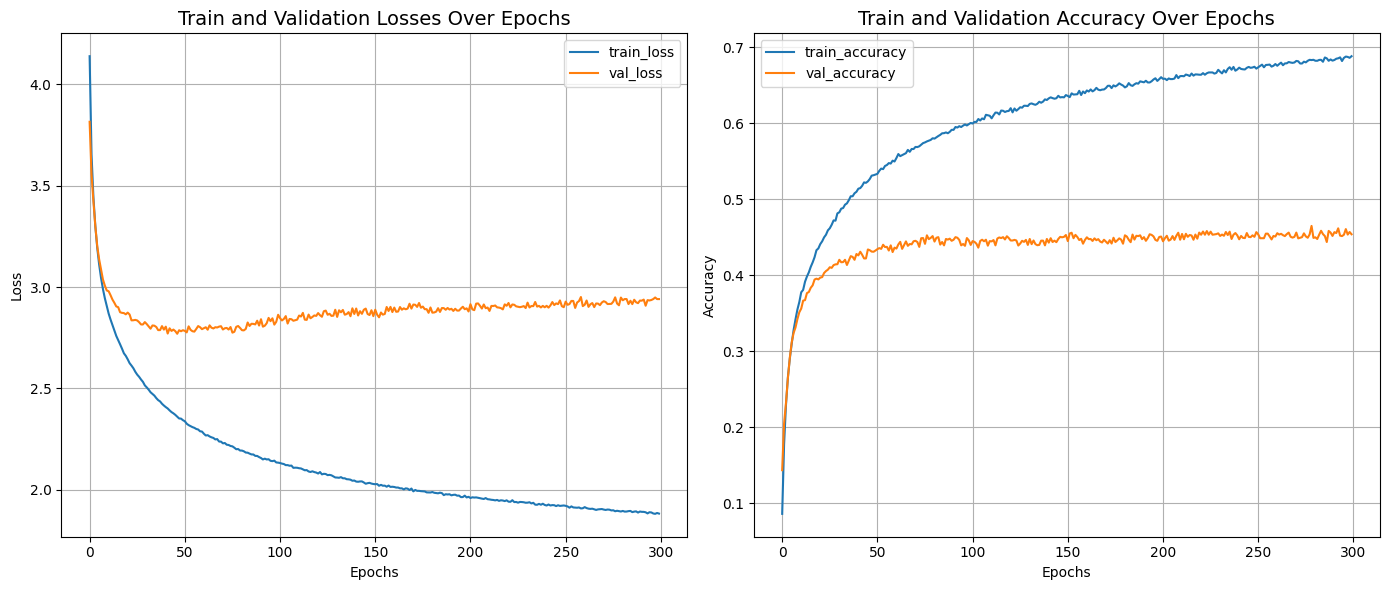

In [ ]:
# 損失（loss）のプロット
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()

# 正解率（accuracy）のプロット
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4643 - loss: 2.9186 - top-5-accuracy: 0.7463
Test loss: 2.89
Test accuracy: 46.88%
Test top 5 accuracy: 74.96%
